In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy.integrate import quad,fixed_quad,quadrature,romberg
from scipy.optimize import root_scalar
from timeit import default_timer as timer
import vegas

In [2]:
# Global constants
# light speed, cm
c = 3*1e10
# kpc to cm
kpc2cm = 3.08*1e21
# erg to MeV
erg2MeV = 624150.913
# year in seconds
yr = 31536000
# Neutrino lumonisity, single specie
Lv = 3e52/6

## SN neutrino and DM halo profile
The neutrino number density per energy
$$
\frac{dn_\nu}{dE_\nu}(r,E_\nu) = \sum_\beta \frac{L_{\nu_{\beta}}}{4\pi r^2 c \langle E_{\nu_\beta}\rangle}f_{\nu_\beta}(E_{\nu_\beta})
$$
where $\beta$ indicates the neutrino flavor and
$$
f_{\nu_\beta}(E_{\nu_\beta}) = \frac{1}{F_2(\eta_\nu)}\frac{1}{T_{\nu_\beta}^3}\frac{E_{\nu_\beta}^2}{\exp(E_{\nu_\beta}/T_{\nu_\beta} -\eta_\nu)+1}
$$
and in general $\eta_\nu=3$ for all flavor $\beta$ and $F_2(\eta_\nu)\approx 18.96$.

In [3]:
def dnvdEv(r,Ev,Lv=Lv):
    """
    Neutrino number density per energy at r
    
    Input
    ------
    Enu: Neutrino energy in MeV
    r: Distance to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s, total time is 10 second
    
    Output
    ------
    Neutrino flux at r: # per Enu per cm**3 per second
    """
    Lv = Lv*erg2MeV
    r = r*kpc2cm
    
    def _fv(Ev,Tv):
        """
        Fermi-Dirac distribution
        """
        return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    L=Lv/(4*np.pi*r**2*c)
    return L*(nue_dist+nueb_dist+4*nux_dist)

NFW DM density profile
$$
n_\chi(r)=\frac{\rho_\chi}{m_\chi}\frac{1}{\frac{r}{r_s}(1+\frac{r}{r_s})^2}
$$
where $\rho_\chi = 184\,{\rm MeV/cm}^3$ and $r_s=24.42\,{\rm kpc}$.

In [4]:
def nx(r,mx,rho=184,rs=24.42):
    """
    DM number density at r
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    rho: characteristic density, default is 184 MeV/cm^3
    rs: characteristic length, default is 24.42 kpc
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    #rs = rs*kpc2cm
    rr=r/rs
    return (rho/mx)/(rr*(1+rr)**2)

## DM emissivity

Upscattered DM emissivity
$$
j_\chi^N(r,p_\chi,\alpha)=\frac{dn_\chi}{dtdp_\chi d\Omega_\alpha}=\frac{dn_\chi}{dtdE_\nu d\Omega_\alpha}\frac{dE_\nu}{dp_\chi}=c\sigma_{\chi \nu}n_\chi(r)\frac{dn_\nu}{dE_\nu}g(\alpha,E_\nu)\frac{dE_\nu}{dp_\chi},
$$
where $g(\alpha,E_\nu)$ is the angular distribution of the upscattered DM, $p$ the upscattered DM momentum and $\alpha$ the scattering angle.

The angluar distribution is given by
$$
g(\alpha,E_\nu)=\frac{dn_\chi}{d\Omega_\alpha}=\frac{\sin[2\tan^{-1}(\gamma \tan\alpha)]}{2\pi \sin\alpha}\frac{\gamma \sec^2\alpha}{1+\gamma^2\tan^2\alpha}
$$
and satisfies the normalization condiation
$$
\int g(\alpha,E_\nu)d\cos\alpha d\phi =1
$$
where $\alpha$ runs from $0$ to $\pi/2$ and $\gamma=E_\chi/m_\chi$. As a matter of fact, the above condition is irrelevant to $\gamma$.

<font color=#DC143C>To build the emissivity function `xemissivity`, in order to keep the numerical result in a fair size for MC intergration (`vegas`), I have removed the factor $c\sigma_{\chi \nu}$ in the function. It can be restored in the last step.</font>

### The $\alpha \to 0$ limit

In the above angluar distribution, when pluggin $\alpha=0$, the $\sin\alpha=0$ causes divergence in the denominator. However, the expression is actually an indetermined $0/0$. We can remove it by L'Hôpital's rule where
$$
\left.\frac{(\sin[2\tan^{-1}(\gamma \tan \alpha)])^\prime}{(\sin\alpha)^\prime}\right|_{\alpha=0}=2\gamma. 
$$
Thus,
$$
\underset{\alpha\to0}{\lim}g(\alpha,E_\nu) =\frac{\gamma^2}{\pi}.
$$

### Find $E_\nu$ with given $T_\chi$ and $\alpha$

We re-express $p_\chi$ in terms of kinetic energy $T_\chi$ via
$$
p_\chi = \sqrt{T_\chi(T_\chi+2m_\chi)}\to dp_\chi = \frac{T_\chi + m_\chi}{\sqrt{T_\chi(T_\chi+2m_\chi)}}dT_\chi \equiv \frac{dT_\chi}{v_\chi(T_\chi,m_\chi)}
$$
thus
$$
\frac{dE_\nu}{dp_\chi}= v_\chi(T_\chi,m_\chi)\frac{dE_\nu}{dT_\chi}.
$$
In the limits of non-relativistic $T_\chi \ll m_\chi$ and of relativistic $T_\chi \gg m_\chi$, they have $v_\chi\to \sqrt{2T_\chi/m_\chi}$ and $v_\chi \to 1$ respectively as expected. Note that the relation between $E_\nu$ and $T_\chi$ can be determined by
$$
T_\chi = \frac{E_\nu^2}{E_\nu+m_\chi/2}\left(\frac{1+\cos\theta_c}{2}\right)
$$
and
$$
\theta_c = 2\tan^{-1}(\gamma \tan\alpha)
$$
where $\gamma = E_{\chi,{\rm cm}}/m_\chi$. Once $\alpha$ and $T_\chi$ are given, $E_\nu$ will be specified, hence numerically we have
$$
\frac{dE_\nu}{dT_\chi} =\underset{dT_{\chi}\to 0}{\lim} \frac{E_\nu(T_\chi+dT_\chi,\alpha)-E_\nu(T_\chi,\alpha)}{dT_\chi}.
$$
We can obtain $E_\nu$ with given $T_\chi$ and $\alpha$ through *root finding method*.

An alternative way is to derive the *analytical expression* of $E_\nu$ in terms of $T_\chi$,
$$
E_{\nu}=\frac{T_{\chi}\sec^{2}\alpha+\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}{2-T_{\chi}\tan^{2}\alpha/m_{\chi}}
$$
where $\gamma$ can be expressed in terms fo $E_\nu$ and $m_\chi$ by
$$
\gamma=\frac{E_{\chi,{\rm cm}}}{m_\chi}=\frac{s+m_\chi^2}{2\sqrt{s}}\frac{1}{m_\chi}=\frac{E_\nu +m_\chi}{\sqrt{m_\chi(2E_\nu + m_\chi)}}.
$$
It is obvious that the numerator of $E_\nu$ is always positive but the denominator is not when $2<T_\chi \tan^2\alpha/m_\chi$. Thus $E_\nu$ will turn negative and becomes unphysical. For the given $\alpha$ and $m_\chi$, the allowed range is $T_\chi < 2m_\chi/\tan^2\alpha$. There is another root for $E_\nu$ but it is always negative.

Thus we have the differential
$$
\frac{dE_\nu}{dT_\chi}= \frac{m_{\chi}^{2}\sec\alpha(2\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}+2m_{\chi}+T_{\chi}\sec^{2}\alpha+T_{\chi})}{(T_{\chi}\tan^{2}\alpha-2m_{\chi})^2\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}.
$$
No matter it is through root finding or analytical expression, both results should agree with each other.

In [5]:
def _gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    s = mx**2+2*Ev*mx
    Ecm = 0.5*(s+mx**2)/np.sqrt(s)
    return Ecm/mx


def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    array: BDM angular distribution
    """
    # From Wen-Hua's note
    if 0 <= alpha <= np.pi/2: 
        beta = Ev/(Ev+mx)
        sec = 1/np.cos(alpha)
        return sec**3*(1-beta**2)/(np.pi*(sec**2-beta**2)**2)
    else:
        return 0
    #gm = _gamma(Ev,mx)
    #if 1e-6 < alpha <= np.pi/2:
    #    # gamma factor in CM frame
    #    return np.sin(2*np.arctan(gm*np.tan(alpha)))*gm*(1/np.cos(alpha))**2 \
    #            /(2*np.pi*np.sin(alpha)*(1+gm**2*np.tan(alpha)**2))
    #elif 0 <= alpha <= 1e-6:
    #    return gm**2/np.pi
    #else:
    #    return 0


def _Tx(Ev,mx,alpha):
    """
    Calculate DM kinetic energy, Eq. (28), and velocity, Eq. (30),
    in terms of lab frame scattering angle
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    array: DM kinetic energy
           DM velocity in the unit of c
           CM frame scatering angle within [0,Pi]
    """
    # gamma factor in CM frame
    gm = _gamma(Ev,mx)
    # CM frame scattering angle
    theta_c = 2*np.arctan(gm*np.tan(alpha))
    
    # Tmax in lab frame
    Tmax = Ev**2/(Ev+0.5*mx)
    Tchi = 0.5*Tmax*(1+np.cos(theta_c))
    return Tchi


def Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame scattering angle alpha via analytical expression
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """
    sec = 1/np.cos(alpha)
    enu = (Tx*sec**2 + sec*np.sqrt(Tx*(2*mx + Tx)))/(2 - Tx*np.tan(alpha)**2/mx)
    return enu


def Ev_root(Tx,mx,alpha,Emax=1e7):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame scattering angle alpha via root finding
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """
    # function for root finding
    _f = lambda ev: _Tx(ev,mx,alpha) - Tx
    # Finding the corresponding Enu
    try:
        Enu = root_scalar(_f,bracket=[0,Emax*mx],method='brentq').root
    except:
        # if the Enu is negative then it is unphysical
        Enu = np.nan
    return Enu


def dEvdTx(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    dTx: arbitrarity small number, default 1e-5
    
    Output
    ------
    tuple: dEv/dTx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


def dEvdTx_root(Tx,mx,alpha,Emax = 1e8,dTx = 1e-5):
    """
    Calculate dEv/dTx via root finding. In contrast to the countpart
    function that based on analytical method, an extra output, the
    corresponding Ev, will be given simultaneously
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    dTx: arbitrarity small number, default 1e-5
    
    Output
    ------
    tuple: (dEv/dTx,Ev)
    """
    #h = 0.5*dTx
    Enu1 = Ev_root(Tx,mx,alpha,Emax)
    Enu2 = Ev_root(Tx + dTx,mx,alpha,Emax)
    return (Enu2 - Enu1)/dTx


def _vx(Tx,mx):
    """
    The dimensionless DM velocity. To restore the physical unit, just time the speed of light c
    """
    return np.sqrt(Tx*(Tx+2*mx))/(Tx+mx)


def xemissivity(Tx,mx,alpha,r,rho=184,rs=24.42,Lv=Lv):
    """
    Upscattered DM emissivity, note the returned result is divided by sigxv and light velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    vx: the DM dimensionless velocity in terms of Tx and mx
    r: the distance from the scattering point to GC, kpc
    rho: DM halo characteristic density, default 184 MeV/cm^3
    rs: DM halo characteristic length, default 24.42 kpc
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    if Tx < 2*mx/np.tan(alpha)**2:    
        dEdT = dEvdTx(Tx,mx,alpha)
        Enu = Ev(Tx,mx,alpha)
        #jx = c*sigxv*nx(r,mx,rho,rs)*dnvdEv(r,Enu,Lv)*g(Enu,mx,alpha)*vx*dEdT
        jx = nx(r,mx,rho,rs)*dnvdEv(r,Enu,Lv)*g(Enu,mx,alpha)*dEdT
    else:
        jx = 0
    return jx

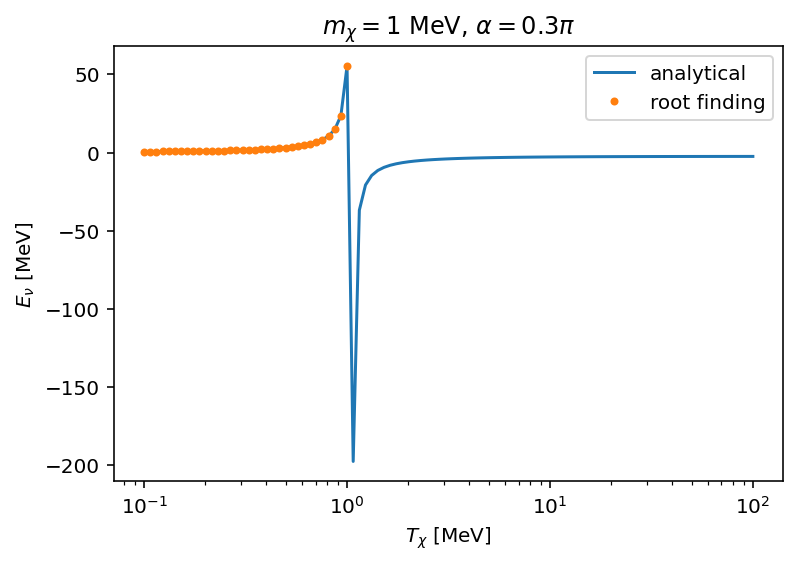

In [6]:
# Checking analytical expression and root finding method
Tx = np.logspace(-1,2,100)
ev = Ev(Tx,1,0.3*np.pi)
# root finding function does not support numpy vectorization
ev_root = []
for tx in Tx:
    root = Ev_root(tx,1,0.3*np.pi)
    ev_root.append(root)

# plot
plt.plot(Tx,ev,label='analytical')
plt.plot(Tx,ev_root,'.',label='root finding')
plt.xscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$E_\nu$ [MeV]')
plt.title(r'$m_\chi=1$ MeV, $\alpha=0.3\pi$')
plt.legend()
plt.show()

The negative $E_\nu$ indicates *uphysical* region. For the given $\alpha$, there is no way to generate such $T_\chi$ in the whole postivie $E_\nu$ region.

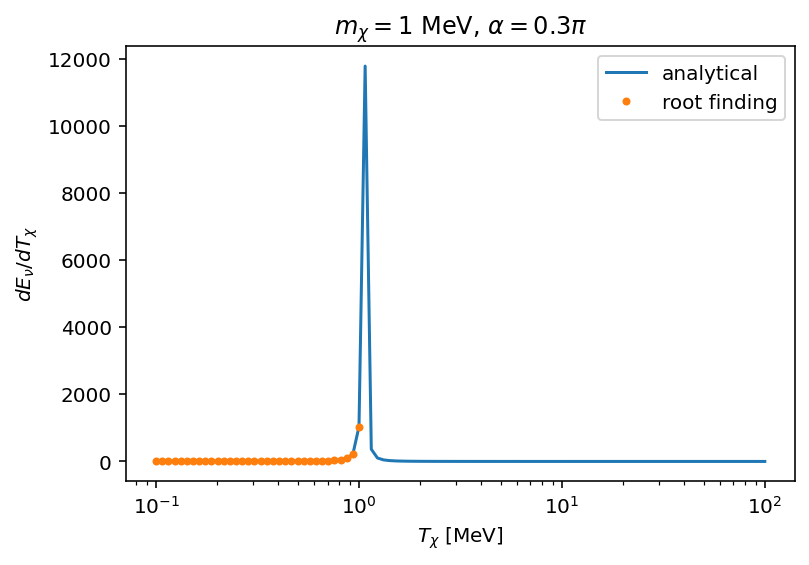

In [7]:
# Checking analytical expression and root finding method
dedt = dEvdTx(Tx,1,0.3*np.pi)
dedt_root = []
for tx in Tx:
    dedt_root.append(dEvdTx_root(tx,1,0.3*np.pi))

# plot
plt.plot(Tx,dedt,label='analytical')
plt.plot(Tx,dedt_root,'.',label='root finding')
plt.xscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$dE_\nu/dT_\chi$')
plt.title(r'$m_\chi=1$ MeV, $\alpha=0.3\pi$')
plt.legend()
plt.show()

## Boosted DM flux at Earth

The upscattered DM flux is given by
$$
\frac{d\Phi^N(T_\chi,t)}{dT_\chi} = 2\pi v_\chi \tau\int_{\cos\theta_{\rm min}}^{\cos\theta_{\rm max}}d\cos\theta \left. j_\chi^N (r,T_\chi,\alpha)\right|_{\frac{r}{c}+\frac{\ell}{v_\chi}=t}
$$
where $\theta \in [0,\pi/2]$. Once $t$ is given, the corresponding $r$ is also known for specified $\ell$ and $\cos\theta$ where
$$
r=\sqrt{\ell^2+R^2-2\ell R \cos\theta}
$$
hence after solving
$$
\frac{r}{c}+\frac{\ell}{v_\chi}=t
$$
we have (I used *Mathematica*)
$$
\ell = \frac{-\sqrt{4 v_{\chi }^2 \left(c^2 t^2-R^2\right) \left(v_{\chi }^2-c^2\right)+v_{\chi }^2 \left(2 c^2 t-2 R \cos \theta  v_{\chi }\right){}^2}+2 c^2 t v_{\chi }-2 R \cos \theta  v_{\chi }^2}{2 \left(c^2-v_{\chi }^2\right)}.
$$
Some input, such as $t$, have no physical solutions for both $\ell$ and $r$ (one or both of them would be negative). Therefore the contribution from such $t$ to the emissivity $j_\chi^N$ should be removed manually.

Another trouble happens when we use $\sin\alpha =R\sin\theta/r$ to obtain $\alpha$. The two cases are degenerate $\sin\alpha = \sin(\pi-\alpha)$. *Numpy* function `arcsin` only returns $\alpha<\pi/2$ result, despite sometimes the true $\alpha$ is larger than $\pi/2$. So instead of using the law of sine, I implemented the law of cosine which will return the true $\alpha$ even it is larger than $\pi/2$. 

Since $\ell$ and $r$ are known, we have
$$
\cos\Theta=\frac{r^2+R^2-\ell^2}{2Rr}
$$
thus
$$
\alpha = \Theta + \theta =\cos^{-1}\left(\frac{r^2+R^2-\ell^2}{2Rr}\right)+\theta.
$$
The above guarantees the true $\alpha$ can be faithfully revealed.

<div align="center"> <img src="./geometry.png"> </div>

In [8]:
def find_lra(t,cos,vx,R=8.5):
    """
    Find l, r and alpha when t, cos\theta, R and vx are given
    
    Input
    ------
    t: time in seconds, 0 starts from the arrival of the SN neutrino at Earth
    cos: cos\theta
    vx: dimensionless DM velocity, v/c
    R: R in kpc, default 8.5 kpc
    
    Output
    ------
    tuple: (l,r,alpha,flag)
           flag is a string label, physical/unphysical, where unphysical
           result should be considered zero contribution to the emissivity
    """
    # convert to CGS unit
    R = R*kpc2cm
    t = t + R/c
    vx = vx*c
    # numerators
    n1 = - np.sqrt(4*vx**2*((c*t)**2-R**2)*(vx**2-c**2)+vx**2*(2*c**2*t-2*R*cos*vx)**2)
    n2 = 2*c**2*t*vx
    n3 = -2*R*cos*vx**2
    # the l
    l = (n1 + n2 + n3)/(2*(c**2 - vx**2))
    # the corresponding r
    r = np.sqrt(l**2 + R**2 - 2*l*R*cos)
    Theta = np.arccos((R**2 + r**2 - l**2)/(2*R*r))
    
    # alpha = Theta + theta
    alpha = Theta + np.arccos(cos)
    
    # Some input, eg., t, will cause l or r is negative, this is not physical and
    # have no contribution to the emissivity.
    # I raise a flag to discrimate such situation and ask the program to set the
    # corresponding emissivity zero manually
    if l < 0 or r < 0 or np.isnan(alpha):
        flag = 'unphysical'
    else:
        flag = 'physical'
    return l/kpc2cm,r/kpc2cm,alpha,flag


def bdmflux(t,Tx,mx,tau=10,sigxv=1e-45,rho=184,rs=24.42,Lv=Lv,R=8.5,method='quad'):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """
    # find DM velocity
    vx = _vx(Tx,mx)
    
    # Define the BDM emissivity jx for integration 
    def jx_tot(cos):
        _,r,alpha,flag = find_lra(t,cos,vx,R)
        if flag == 'physical':
            return sigxv*tau*c*xemissivity(Tx,mx,alpha,r,rho,rs,Lv)
        else:
            return 0
        
    return 2*np.pi*(vx*c)*(quad(jx_tot,0,0.5)[0]+quad(jx_tot,0.5,0.8)[0]+quad(jx_tot,0.8,0.9)[0]+quad(jx_tot,0.9,0.99)[0]
                           +quad(jx_tot,0.99,0.999)[0]+quad(jx_tot,0.999,0.9999)[0]
                           +quad(jx_tot,0.9999,0.99999)[0]+quad(jx_tot,0.99999,1)[0])

In [9]:
# All in MeV
mx1 = 0.01
mx2 = 1
mx3 = 10
Tx = 10

# years
yrls=np.logspace(-1,5,100)

fluxmx1=[]
for y in yrls:
    fluxmx1.append(bdmflux(y*yr,Tx,mx1))

fluxmx2=[]
for y in yrls:
    fluxmx2.append(bdmflux(y*yr,Tx,mx2))
    
fluxmx3=[]
for y in yrls:
    fluxmx3.append(bdmflux(y*yr,Tx,mx3))

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


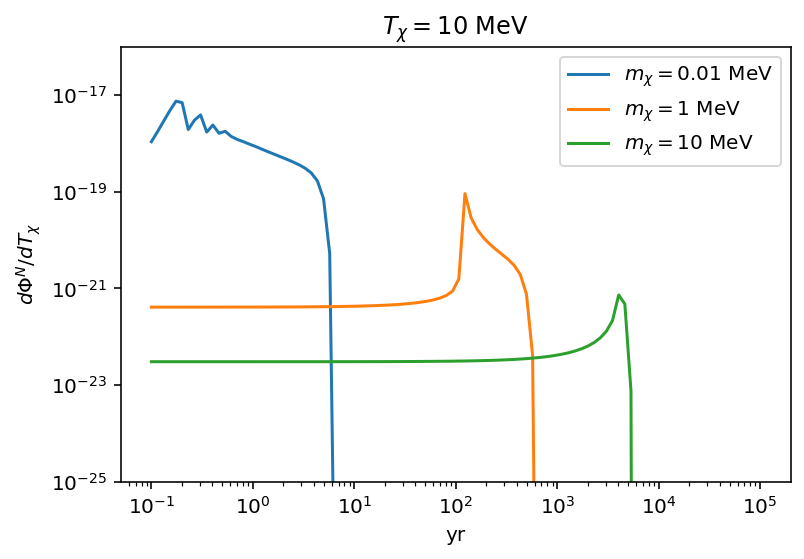

In [10]:
plt.plot(yrls,fluxmx1,label='$m_\chi=$' +str(mx1) +' MeV')
plt.plot(yrls,fluxmx2,label='$m_\chi=$' +str(mx2) +' MeV')
plt.plot(yrls,fluxmx3,label='$m_\chi=$' +str(mx3) +' MeV')
#plt.plot(yrls_v,fluxmx1v,'r.')
#plt.plot(yrls_v,fluxmx2v,'g.')
#plt.plot(yrls_v,fluxmx3v,'b.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi^N/dT_\chi$')
plt.title(r'$T_\chi =$'+str(Tx)+' MeV')
plt.legend(loc='best')
plt.ylim(1e-25,1e-16)
#plt.savefig('sharp_peak.png',dpi=150)
plt.show()

In [11]:
def diag(t,Tx,mx,events=100,crange=[0,1],rho=184,rs=24.42,Lv=Lv,R=8.5):
    """
    diagnostic
    """
    # find DM velocity
    vx = _vx(Tx,mx)
    
    # Define the BDM emissivity jx for integration 
    def jx_tot(cos):
        _,r,alpha,flag = find_lra(t,cos,vx,R)
        if flag == 'physical':
            return alpha,xemissivity(Tx,mx,alpha,r,rho,rs,Lv)
        else:
            return alpha,0
    cos_ls = np.linspace(crange[0],crange[1],events)
    alpha_ls = []
    xemis_ls = []
    for c in cos_ls:
        a,x = jx_tot(c)
        alpha_ls.append(a)
        xemis_ls.append(x)
    return cos_ls,np.array(alpha_ls),np.array(xemis_ls)

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


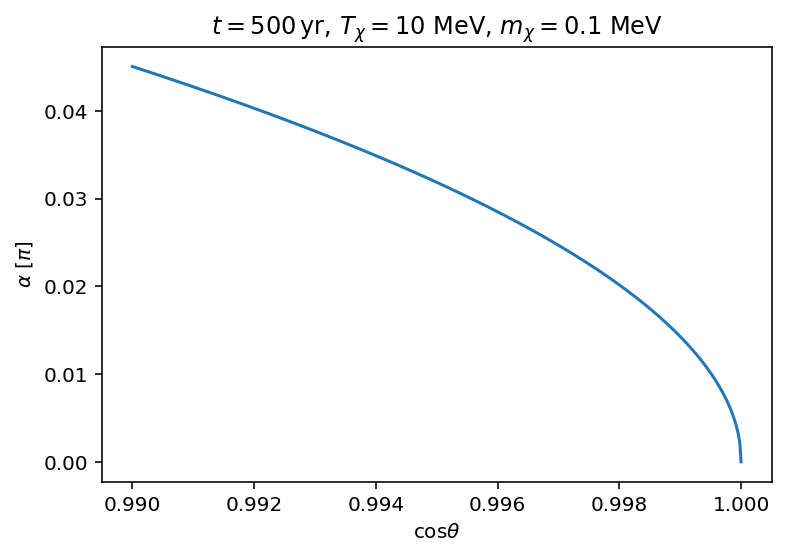

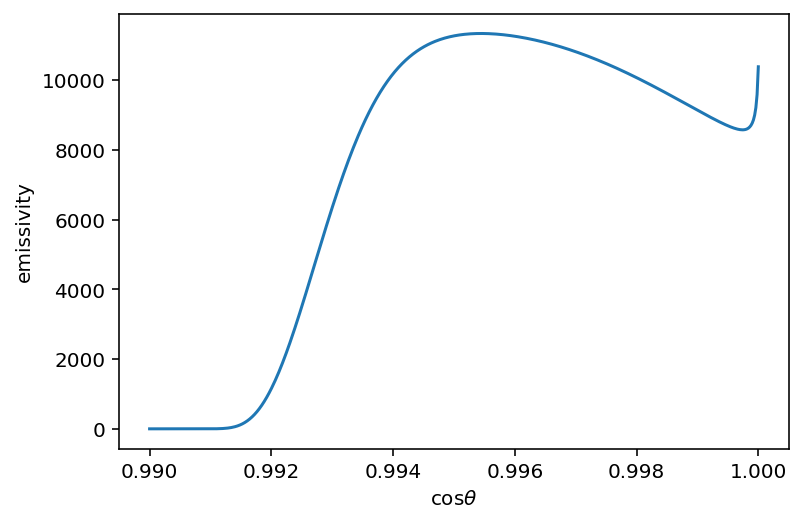

In [12]:
mdm = 0.1
Tdm = 10
cos_ls,alpha_ls,xemis_ls=diag(0.1*yr,Tdm,mdm,events=500,crange=[0.99,1])
plt.plot(cos_ls,alpha_ls/np.pi)
plt.title(r'$t=500\,{\rm yr},\,T_\chi=$'+str(Tdm)+r' MeV, $m_\chi=$'+str(mdm)+' MeV')
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$\alpha$ [$\pi$]')
#plt.savefig('cos-alpha.png',dpi=150)
plt.show()
plt.plot(cos_ls,xemis_ls)
#plt.yscale('log')
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'emissivity')
#plt.savefig('cos-emm.png',dpi=150)
plt.show()